<a href="https://colab.research.google.com/github/SophieD517/MTL/blob/main/SineWaves/Sine_ConvNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

##Imports

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m  
import os
import torch
import seaborn as sns
import random
!pip install wandb
!wandb login
import wandb
wandb.init(project="sine_convnn", entity="sophied")
import plotly.express as px
import torch.nn.functional as F
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')
torch.manual_seed(0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Currently logged in as: sophied. Use `wandb login --relogin` to force relogin


epochs,▁
k,█▁
latent_dim,▁
loss,▃▃▂▂▃▃▁▂▁▁▂▂▁▂█▂▂▁▂▁▂▂▂▂▃▁▁▂▂▂▁▁▁▂▁▁▁▁▂▁
lr,▁
p,▁▁
s,▁▁
w,▁█
epochs,1000
k,3
latent_dim,10


In [3]:
# https://github.com/hcarlens/pytorch-tabular/blob/master/fast_tensor_data_loader.py
class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

##Generating Data

In [4]:
#y=asin(bx-h)+k
a = np.random.uniform(low=-5, high=5, size=10000).tolist()
b = np.random.uniform(low=-5, high=5, size=10000).tolist()
h = np.random.uniform(low=-5, high=5, size=10000).tolist()
k = np.random.uniform(low=-5, high=5, size=10000).tolist()

mlist = []
for i, t in enumerate(a):
  mlist.append([a[i]*m.sin(b[i]*x-h[i])+k[i] for x in np.arange(-10*m.pi, 10*m.pi, m.pi/10)])
data = pd.DataFrame(mlist)

data['a'] = a
data['b'] = b
data['h'] = h
data['k'] = k

msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]
msk2 = np.random.rand(len(test)) < 0.8
validate = test[~msk2]
test = test[msk2]

train_data = torch.tensor(train.values, requires_grad=True, dtype=torch.float32)
test_data = torch.tensor(test.values, requires_grad=True, dtype=torch.float32)
validate_data = torch.tensor(validate.values, requires_grad=True, dtype=torch.float32)

X = train_data[:, :200].mul(0.1)
A = train_data[:, 200:201].unsqueeze(dim=1).mul(0.2)
B = train_data[:, 201:202].unsqueeze(dim=1).mul(0.2)
H = train_data[:, 202:203].unsqueeze(dim=1).mul(0.2)
K = train_data[:, 203:].unsqueeze(dim=1).mul(0.2)

X_test = test_data[:, :200].mul(0.1)
A_test = test_data[:, 200:201].unsqueeze(dim=1).mul(0.2)
B_test = test_data[:, 201:202].unsqueeze(dim=1).mul(0.2)
H_test = test_data[:, 202:203].unsqueeze(dim=1).mul(0.2)
K_test = test_data[:, 203:].unsqueeze(dim=1).mul(0.2)

train_data.shape

torch.Size([8028, 204])

##Plotting Data

In [5]:
# x1 = [x for x in np.arange(-10*m.pi, 10*m.pi, m.pi/10)]
# for index, row in data.drop(columns=['a', 'b', 'h', 'k']).iterrows():
#   plt.plot(x1, row) 
# plt.ylim(-10, 10)
# plt.xlim(-10*m.pi, 10*m.pi)

In [6]:
# sns.histplot(data=data, x='a')

##DataLoader

In [7]:
# https://github.com/hcarlens/pytorch-tabular/blob/master/fast_tensor_data_loader.py
class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

#Define Network

In [26]:
def plot_comp(a, recon1, recon2, text='', title='Epoch ', epoch='', col='black'):
  fig, ax = plt.subplots()
  x1 = train_data[6500:6800, a:a+1].mul(.1).squeeze().detach()
  y1 = recon1[:, a:a+1].squeeze().detach()
  x2 = train_data[:500, a:a+1].mul(.1).squeeze().detach()
  y2 = recon2[:, a:a+1].squeeze().detach()
  ax.set_ylabel('recon')
  ax.set_xlabel('orig')
  ax.set_title(title+epoch, color=col)
  plt.xlim(-1, 1)
  plt.ylim(-1, 1)
  ax.scatter(x1, y1, s=1, color='orange')
  ax.scatter(x2, y2, s=1, color='purple')
  dist = np.array([-1, 0, 1])
  ax.plot(dist, dist, color='#d3d3d3', linewidth=1)
  a1, b1 = np.polyfit(x1, y1, 1)
  a2, b2 = np.polyfit(x2, y2, 1)
  ax.plot(dist, a1*dist+b1, color='orange', linewidth=1)
  ax.plot(dist, a2*dist+b2, color='purple', linewidth=1)
  plt.text(-.9, .75, text, color=col)

def func(w,k,p,s):
  out = (w-k+2*p)/s+1
  return int(out)

def plot_reconstruction(x_test, recon, title=''):
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(1, 1)
    x = [x for x in np.arange(-10*m.pi, 10*m.pi, m.pi/10)]
    sam = random.sample(range(1, 100), 3)
    colors = ['mistyrose', '#ccffb3', '#ADD8E6']
    a = 0
    for i in sam:
      plt.plot(x, x_test.detach().numpy().tolist()[i], color=colors[a], linewidth=5)
      a+=1
    colors = ['salmon', 'darkolivegreen', 'darkcyan']
    a = 0
    for i in sam:
      plt.plot(x, recon.detach().numpy().tolist()[i], '--', color=colors[a], linewidth=1)
      a+=1
    fig.set_size_inches(12, 8)
    plt.ylim(-10, 10)
    plt.xlim(-10*m.pi, 10*m.pi)
    plt.title(title)
    plt.show()

In [27]:
class Starlight(nn.Module):
  def __init__(self, latent_dim, set1, set2, drop_rate):
    super().__init__()

    self.enc_conv1 = nn.Conv1d(in_channels=200, out_channels=set1['w'], kernel_size=set1['k'], padding=set1['p'], stride=set1['s'])
    self.enc_pool = nn.MaxPool1d(3, padding=1, stride=2, return_indices=True)
    self.enc_conv2 = nn.Conv1d(in_channels=set1['w'], out_channels=set2['w'], kernel_size=set2['k'], padding=set2['p'], stride=set2['s'])
    self.enc_lin1 = nn.Linear(int(set2['w']*((2*set1['p']+2-set1['k'])/set1['s'])*((2*set2['p']+2-set2['k'])/set2['s'])), latent_dim)

    self.dec_lin1 = nn.Linear(latent_dim, set2['w'])
    self.dec_deconv1 = nn.ConvTranspose1d(in_channels=set2['w'], out_channels=set1['w'], kernel_size=set2['k'], padding=set2['p'], stride=set2['s'])
    self.dec_unpool = nn.MaxUnpool1d(3, padding=1, stride=2)
    self.dec_deconv2 = nn.ConvTranspose1d(in_channels=set1['w'], out_channels=200, kernel_size=set1['k'], padding=set1['p'], stride=set1['s'])

    self.dropout = nn.Dropout(drop_rate)

    self.latent_dim = latent_dim
    
 
  def encoder(self, x):
    x = x.unsqueeze(dim=2)
    self.shape1 = x.shape
    x = self.enc_conv1(x)
    x, self.indices1 = self.enc_pool(x)
    x = F.relu(x)
    self.shape2 = x.shape
    x = self.enc_conv2(x)
    x, self.indices2 = self.enc_pool(x)
    x = F.relu(x)
    x = torch.flatten(x, start_dim=1)
    self.a_given_shape = x.shape[1]
    x = nn.Linear(self.a_given_shape, self.latent_dim)(x)
    # x = self.enc_lin1(x)
    return x

  def decoder(self, x):
    x = F.relu(x)
    # x = self.dec_lin1(x)
    x = nn.Linear(self.latent_dim, self.a_given_shape)(x)
    x = F.relu(x.unsqueeze(dim=2))
    x = self.dec_unpool(x.view(self.indices2.shape).squeeze(), self.indices2.squeeze())#, output_size=self.shape2)
    x = self.dec_deconv1(x)
    x = F.relu(x)
    x = self.dec_unpool(x, self.indices1)#, output_size=self.shape1)
    x = self.dec_deconv2(x)
    x = torch.flatten(x, start_dim=1)
    return x


  def forward(self, x): 
    ls = self.encoder(x)
    return ls, self.decoder(ls)

#######

#Train One Batch

In [28]:
def plots(a, recon, text='', title='Epoch ', epoch='', col='black'):
  fig, ax = plt.subplots()
  x = train_data[:100, a:a+1].mul(.1).squeeze().detach()
  y = recon[:, a:a+1].squeeze().detach()
  ax.set_ylabel('recon')
  ax.set_xlabel('orig')
  ax.set_title(title+epoch, color=col)
  plt.xlim(-1, 1)
  plt.ylim(-1, 1)
  ax.scatter(x, y, s=1, color='red')
  dist = np.array([-1, 0, 1])
  ax.plot(dist, dist, color='#d3d3d3', linewidth=1)
  a, b = np.polyfit(x, y, 1)
  ax.plot(dist, a*dist+b, color='red', linewidth=1)
  plt.text(-.9, .75, text, color=col)

inp = train_data[:100, :200].mul(.1)
set1 = {'w': 45, 'k': 7, 'p': 3, 's': 1}
set2 = {'w': 73, 'k': 3, 'p': 3, 's': 1}
model = Starlight(10, set1, set2, 0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.009402)
def train_one_batch(epochs=1000):
  wandb.log(set1)
  wandb.log(set2)
  wandb.log({'latent_dim': 10, 'epochs': 1000, 'lr': 0.009402})
  for epoch in range(epochs):
    optimizer.zero_grad()
    ls, recon = model(inp)
    loss = torch.nn.MSELoss()(recon, inp)
    wandb.log({'loss': loss})
    loss.backward(retain_graph=True)
    optimizer.step()
    if (epoch+1) % 100==0:
      print(loss)
    if (epoch+1) % (epochs/10) == 0:
      text = 'Loss '+ str(epoch+1)+ ': '+ str(loss.detach().numpy())
      if loss > .005:
        plots(np.random.randint(low=0, high=200), recon, text, epoch=str(epoch+1))
      else:
        plots(np.random.randint(low=0, high=200), recon, text, epoch=str(epoch+1), col='green')
    if loss<0.01:
      torch.save(model.state_dict(), input('filename')+'.zip')
      break
  plot_reconstruction(inp, model(inp)[1], title='train')
  plot_reconstruction(validate_data[:, :200], model(validate_data[:, :200])[1], title='validate')

tensor(0.0777, grad_fn=<MseLossBackward0>)
tensor(0.2784, grad_fn=<MseLossBackward0>)
tensor(0.0935, grad_fn=<MseLossBackward0>)
tensor(0.0552, grad_fn=<MseLossBackward0>)
tensor(0.0554, grad_fn=<MseLossBackward0>)
tensor(0.0594, grad_fn=<MseLossBackward0>)
tensor(0.0968, grad_fn=<MseLossBackward0>)
tensor(0.0706, grad_fn=<MseLossBackward0>)
tensor(0.0511, grad_fn=<MseLossBackward0>)
tensor(0.0581, grad_fn=<MseLossBackward0>)


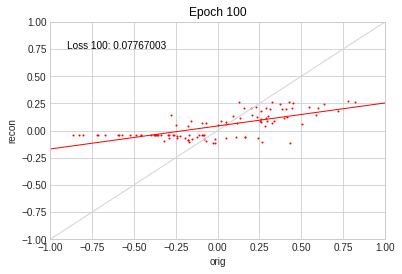

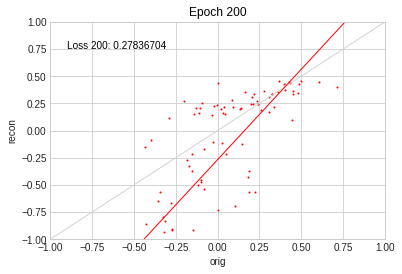

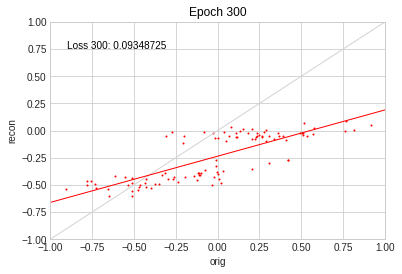

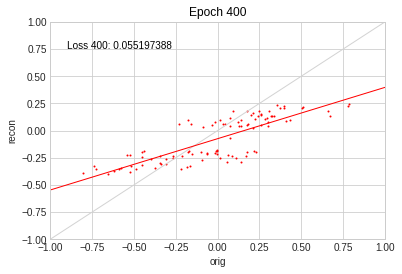

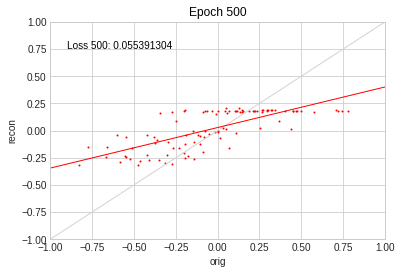

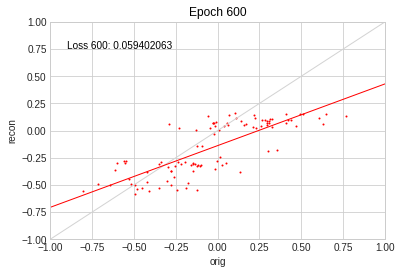

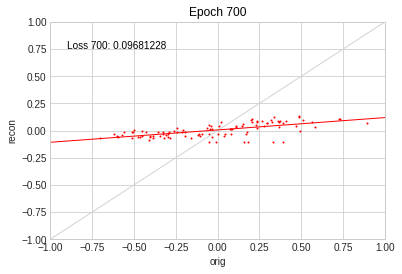

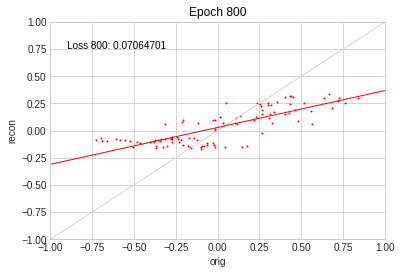

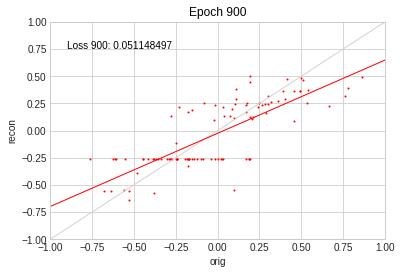

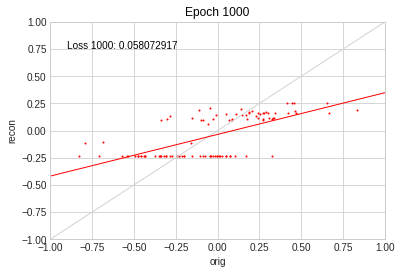

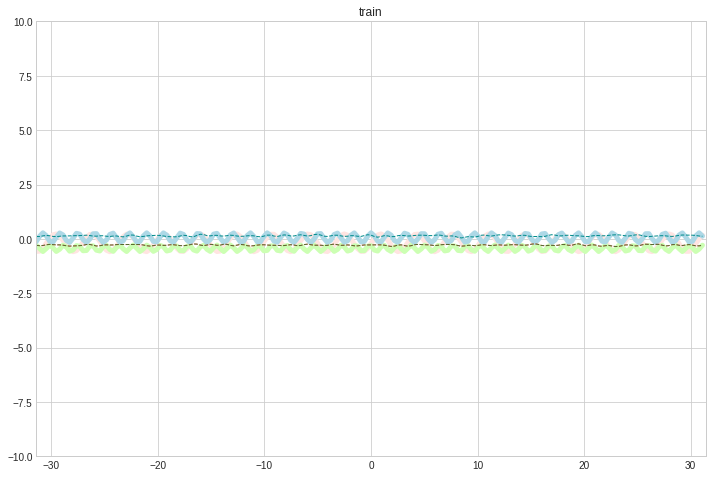

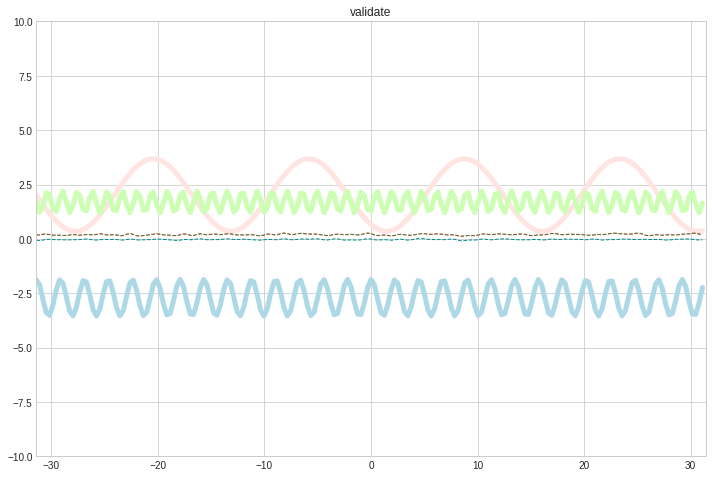

In [29]:
wandb.init(project="sine_convnn", entity="sophied")
train_one_batch(1000)

In [ ]:
torch.save(model.state_dict(), 'one_batch.zip')

#train recon

In [ ]:
x = train_data[:, :200].mul(.1)
model = Starlight(10, {'w': 99, 'k': 7, 'p': 5, 's': 1}, {'w': 55, 'k': 3, 'p': 1, 's': 1}, 0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
def train_all(epochs, bs=64):
  batches = FastTensorDataLoader(x, batch_size=bs, shuffle=False)
  for epoch in range(epochs):
    for idx, batch in enumerate(batches):
      optimizer.zero_grad()
      ls, recon = model(batch[0])
      loss = torch.nn.MSELoss()(recon, batch[0])
      loss.backward(retain_graph=True)
      optimizer.step()
    if (epoch+1) % 10==0:
      print(loss)
    if (epoch+1) % (epochs/10) == 0:
      text = 'Loss '+ str(epoch+1)+ ': '+ str(loss.detach().numpy())
      optimizer.zero_grad()
      if loss > .005:
        plot_comp(np.random.randint(low=0, high=200), model(x[6500:6800, :200])[1], model(x[:500, :200])[1], text, epoch=str(epoch+1))
      else:
        plot_comp(np.random.randint(low=0, high=200), model(x[6500:6800, :200])[1], model(x[:500, :200])[1], text, epoch=str(epoch+1), col='green')
    if loss<0.01:
      torch.save(model.state_dict(), input('filename')+'.zip')
      break
  plot_reconstruction(train_data[:, :200], model(train_data[:, :200])[1])
  plot_reconstruction(validate_data[:, :200], model(validate_data[:, :200])[1])

In [ ]:
train_all(100, bs=128)

tensor(0.0443, grad_fn=<MseLossBackward0>)
tensor(0.0439, grad_fn=<MseLossBackward0>)
tensor(0.0365, grad_fn=<MseLossBackward0>)
tensor(0.0382, grad_fn=<MseLossBackward0>)
tensor(0.0383, grad_fn=<MseLossBackward0>)
tensor(0.0379, grad_fn=<MseLossBackward0>)
tensor(0.0362, grad_fn=<MseLossBackward0>)
tensor(0.0447, grad_fn=<MseLossBackward0>)
tensor(0.0353, grad_fn=<MseLossBackward0>)
tensor(0.0390, grad_fn=<MseLossBackward0>)


#Sweep

In [30]:
inp = train_data[:100, :200].mul(.1)

def train_one_batch(epochs=100):
  with wandb.init(config=None):
    config=wandb.config
    model = Starlight(13, {'w': config.w1, 'k': config.k1, 'p': config.p1, 's': 1}, {'w': config.w2, 'k': config.k2, 'p': config.p2, 's': 1}, 0)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    for epoch in range(epochs):
      optimizer.zero_grad()
      ls, recon = model(inp)
      loss = torch.nn.MSELoss()(recon, inp)
      loss.backward(retain_graph=True)
      optimizer.step()
      wandb.log({'loss': loss})

In [31]:
!pip install wandb
import wandb
!wandb login

wandb.init(project="conv_nn", entity="sophied")
sweep_config = {'method': 'bayes'}
metric = {'name': 'loss', 'goal': 'minimize'}
sweep_config['metric'] = metric
parameters_dict = {
    'lr': {
        'min': 0.0001,
        'max': 0.01,
        'distribution': 'uniform'
    },
    'w1': {'values': [11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77]},
    'w2': {'values': [11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77]},
    'k1': {'values': [3,5,7]},
    'k2': {'values': [3,5]},
    'p1': {'values': [2,3,4]},
    'p2': {'values': [2,3]}
}

sweep_config['parameters'] = parameters_dict
sweep_id = wandb.sweep(sweep_config, project="conv_nn")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Currently logged in as: sophied. Use `wandb login --relogin` to force relogin


epochs,▁
k,█▁
latent_dim,▁
loss,▆▂▂▂▂▁▄▅▆▃▃▅▂▂▃▂▂▃▅▃▃▃▂▄▂▂▄▅▄▄▃█▁▅▃▄▂▄▂▂
lr,▁
p,▁▁
s,▁▁
w,▁█
epochs,1000
k,3
latent_dim,10


Create sweep with ID: 2bsbb7zx
Sweep URL: https://wandb.ai/sophied/conv_nn/sweeps/2bsbb7zx


In [ ]:
wandb.agent(sweep_id, train_one_batch, count=1000)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: bq6b4udn with config:
wandb: 	k1: 3
wandb: 	k2: 5
wandb: 	lr: 0.005890106348682947
wandb: 	p1: 3
wandb: 	p2: 3
wandb: 	w1: 67
wandb: 	w2: 61


loss,▆▆▄▂▂▂▃▂▁▂▂▃▁▁▁▁▁▂▃▃▂▂▁▃▃▂█▂▂▁▂▁▂▁▁▁▂▁▂▁
loss,0.04905


wandb: Agent Starting Run: sqhrkvho with config:
wandb: 	k1: 5
wandb: 	k2: 3
wandb: 	lr: 0.009474358972617494
wandb: 	p1: 2
wandb: 	p2: 3
wandb: 	w1: 73
wandb: 	w2: 43


loss,████▇▇▃▂▁▂▂▂▁▂▃▄▂▅▁▂▁▂▂▃▂▁▁▂▁▂▁█▂▅▄▃▂▁▂▂
loss,0.04991


wandb: Agent Starting Run: gcn1m53v with config:
wandb: 	k1: 5
wandb: 	k2: 5
wandb: 	lr: 0.0007284736866472002
wandb: 	p1: 2
wandb: 	p2: 2
wandb: 	w1: 15
wandb: 	w2: 75


wandb: ERROR Run gcn1m53v errored: RuntimeError('Given transposed=1, weight of size [75, 15, 5], expected input[1, 100, 149] to have 75 channels, but got 100 channels instead')
wandb: Agent Starting Run: 8c03npxp with config:
wandb: 	k1: 7
wandb: 	k2: 5
wandb: 	lr: 0.0008947617343358078
wandb: 	p1: 2
wandb: 	p2: 3
wandb: 	w1: 25
wandb: 	w2: 77


wandb: ERROR Run 8c03npxp errored: RuntimeError('Trying to create tensor with negative dimension -231: [13, -231]')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b88wkida with config:
wandb: 	k1: 5
wandb: 	k2: 5
wandb: 	lr: 0.004323781784748916
wandb: 	p1: 3
wandb: 	p2: 3
wandb: 	w1: 73
wandb: 	w2: 59


wandb: ERROR Run b88wkida errored: RuntimeError('Found an invalid max index: 3 (output volumes are of size 3x1')
wandb: Agent Starting Run: 6nirzpcq with config:
wandb: 	k1: 3
wandb: 	k2: 3
wandb: 	lr: 0.008241703474695923
wandb: 	p1: 3
wandb: 	p2: 2
wandb: 	w1: 69
wandb: 	w2: 47


loss,▇▆▆▅▂▂▂▁▃▃▂▂█▂▂▃▂▁▂▁▂▃▂▂▁▁▃▂▂▂▁▂▂▁▂▁▂▁▂▂
loss,0.05065


wandb: Agent Starting Run: smp1az0b with config:
wandb: 	k1: 5
wandb: 	k2: 3
wandb: 	lr: 0.004816288010503262
wandb: 	p1: 3
wandb: 	p2: 3
wandb: 	w1: 37
wandb: 	w2: 47


wandb: ERROR Run smp1az0b errored: RuntimeError('Found an invalid max index: 5 (output volumes are of size 5x1')
wandb: Agent Starting Run: odp5lhml with config:
wandb: 	k1: 3
wandb: 	k2: 5
wandb: 	lr: 0.005895716960442917
wandb: 	p1: 4
wandb: 	p2: 2
wandb: 	w1: 51
wandb: 	w2: 15


wandb: ERROR Run odp5lhml errored: RuntimeError('Found an invalid max index: 3 (output volumes are of size 3x1')
wandb: Agent Starting Run: y19my63g with config:
wandb: 	k1: 5
wandb: 	k2: 5
wandb: 	lr: 0.000968326233662346
wandb: 	p1: 3
wandb: 	p2: 2
wandb: 	w1: 47
wandb: 	w2: 55


wandb: ERROR Run y19my63g errored: RuntimeError('Given transposed=1, weight of size [55, 47, 5], expected input[1, 100, 109] to have 55 channels, but got 100 channels instead')
wandb: Agent Starting Run: ij0sb9db with config:
wandb: 	k1: 5
wandb: 	k2: 5
wandb: 	lr: 0.008455030601852752
wandb: 	p1: 4
wandb: 	p2: 2
wandb: 	w1: 69
wandb: 	w2: 53


loss,█▇▃▁▂▁▆▆▃▆▁▁▁▂▂▇▂▅▃▁▃▂▄▄▂▂▁▂▅▃▃▂▇▁▃▃▂▂▂▁
loss,0.0449


wandb: Agent Starting Run: y2er7rms with config:
wandb: 	k1: 5
wandb: 	k2: 3
wandb: 	lr: 0.002951053631158628
wandb: 	p1: 4
wandb: 	p2: 3
wandb: 	w1: 67
wandb: 	w2: 51


loss,▆▆▃▂▁▁▂▁▂▂▃▁▂▁▁█▂▃▂▁▁▁▁▂▁▃▁▁▁▁▁▁▃▂▂▁▁▁▃▂
loss,0.0518


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2vccr41s with config:
wandb: 	k1: 3
wandb: 	k2: 3
wandb: 	lr: 0.0013067121940917626
wandb: 	p1: 2
wandb: 	p2: 2
wandb: 	w1: 23
wandb: 	w2: 35


wandb: ERROR Run 2vccr41s errored: RuntimeError('Found an invalid max index: 3 (output volumes are of size 3x1')
wandb: Agent Starting Run: k0qa7ehd with config:
wandb: 	k1: 3
wandb: 	k2: 3
wandb: 	lr: 0.008799589679851838
wandb: 	p1: 3
wandb: 	p2: 2
wandb: 	w1: 47
wandb: 	w2: 25


loss,██▇▆▄▂▄▂▂▂▂▁▁▁▁▂▂▃▄▄▁▂▃▄▂▁▂▂▂▂▃▃▁▂▁▄▃▃▁▁
loss,0.04293


wandb: Agent Starting Run: o004sioh with config:
wandb: 	k1: 5
wandb: 	k2: 5
wandb: 	lr: 0.001847223517490991
wandb: 	p1: 3
wandb: 	p2: 3
wandb: 	w1: 11
wandb: 	w2: 59


wandb: ERROR Run o004sioh errored: RuntimeError('Found an invalid max index: 3 (output volumes are of size 3x1')
wandb: Agent Starting Run: e0ig3nsc with config:
wandb: 	k1: 5
wandb: 	k2: 5
wandb: 	lr: 0.006849868067554599
wandb: 	p1: 4
wandb: 	p2: 3
wandb: 	w1: 65
wandb: 	w2: 75


loss,█▇▂▃▂▃▄▂▅▁▃▁▁▂▁▅▃▂▁▂▃▅▄▁▅▁█▄▅▅▄▃▁▄▆▄▁▃▂▇
loss,0.10913
